In [ ]:
import torch
from torchvision import transforms, utils
import torchvision
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from PIL import Image
import cv2
import glob
import random
import os
import numpy as np
import argparse
import math

In [ ]:
# !git clone https://github.com/ryanliwag/temp.git

In [ ]:
# Dataset loader
transforms_orig = transforms.Compose([
                transforms.RandomRotation(15),
                transforms.Resize((128, 128), Image.BICUBIC),
                transforms.RandomHorizontalFlip()])

transforms_bw = transforms.Compose([
                transforms.Grayscale(num_output_channels=1),
                transforms.ToTensor()])


transforms_rgb = transforms.Compose([
                transforms.ToTensor()])

class ImageDataset(Dataset):
    def __init__(self, root, transforms_orig=None, transforms_bw=None, transforms_rgb=None):
        '''
        Args:
            csv_file (string)
            transform (callable, optional)
        '''
        
        files = glob.glob('%s/*.*' % root)
        self.training_files = files * 4
        self.transforms_orig = transforms_orig
        self.transforms_rgb = transforms_rgb
        self.transforms_bw = transforms_bw
        
    def __len__(self):
        return len(self.training_files)
    
    def __getitem__(self, idx):
        img = Image.open(self.training_files[idx])
        
        orig_image = self.transforms_orig(img)
        
        true_image = self.transforms_rgb(orig_image)
        bw_image = self.transforms_bw(orig_image)
        
        return {"true_image": true_image, "gen_image": bw_image}

In [ ]:
training_generator = ImageDataset(root="/content/training", transforms_orig=transforms_orig,
                                                    transforms_rgb=transforms_rgb, 
                                                    transforms_bw=transforms_bw)


In [ ]:
batch_size = 5
dataloader = DataLoader(
    training_generator,
    batch_size=batch_size,
    shuffle=True
)

torch.Size([5, 3, 128, 128])


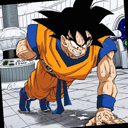

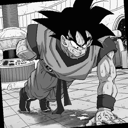

torch.Size([5, 3, 128, 128])


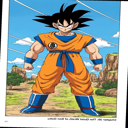

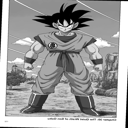

torch.Size([5, 3, 128, 128])


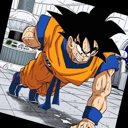

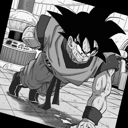

In [ ]:
to_pil = torchvision.transforms.ToPILImage()

for idx, image in enumerate(dataloader):
    res = to_pil(image["true_image"][0])
    bw = to_pil(image["gen_image"][0])
    print(image["true_image"].shape)
    display(res)
    display(bw)
    if idx == 2:
        break

In [ ]:
  class UNet(nn.Module):
    
    def unet_conv(self, ch_in, ch_out, is_leaky):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and ReLU/Leaky ReLU.
        """
        if is_leaky:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                nn.Conv2d(ch_in, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU(),
                nn.Conv2d(ch_out, ch_out, 3, padding=1),
                nn.BatchNorm2d(ch_out),
                nn.ReLU()
            )
        
    def up(self, ch_in, ch_out):
        """
        Applies a 2D bilinear upsampling to the input image which scales
        the image 2x times, followed by a convolution with a 1x1 kernel. 
        """
        return nn.Sequential(
            nn.ConvTranspose2d(ch_in, ch_out, 3, 2, 1, 1), 
            nn.ReLU()
        )
    
    def __init__(self, is_leaky):
        """
        In the constructer, all the convolutional, upsampling and max pooling 
        units are instantiated and assigned as member variables. 
        """
        super(UNet, self).__init__()
        
        # First encoding layer
        self.conv1 = self.unet_conv(1, 64, is_leaky)
        # Second encoding layer
        self.conv2 = self.unet_conv(64, 128, is_leaky)
        # Third encoding layer
        self.conv3 = self.unet_conv(128, 256, is_leaky)
        # Fourth encoding layer
        self.conv4 = self.unet_conv(256, 512, is_leaky)
        # Fifth encoding layer
        self.conv5 = self.unet_conv(512, 1024, is_leaky)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # First Upsampling layer
        self.up1 = self.up(1024, 512)
        # Second Upsampling layer
        self.up2 = self.up(512, 256)
        # Third Upsampling layer
        self.up3 = self.up(256, 128)
        # Fourth Upsampling layer
        self.up4 = self.up(128, 64)
        
        # First decoding layer
        self.conv6 = self.unet_conv(1024, 512, False)
        # Second decoding layer
        self.conv7 = self.unet_conv(512, 256, False)
        # Third decoding layer
        self.conv8 = self.unet_conv(256, 128, False)
        # Fourth decoding layer
        self.conv9 = self.unet_conv(128, 64, False)
        
        # Last layer
        self.conv10 = nn.Conv2d(64, 3, 1)

    def forward(self, x):
        """ 
        An input tensor of a black and white image is accepted and
        passed through the U-Net model. A colored image in CieLAB color
        space is returned as the result. 
        """
        # Encoding path
        x1 = self.conv1(x)
        x2 = self.conv2(self.pool(x1))
        x3 = self.conv3(self.pool(x2))
        x4 = self.conv4(self.pool(x3))
        x5 = self.conv5(self.pool(x4))
        
        # Decoding path
        x = self.conv6(torch.cat((x4, self.up1(x5)), 1))
        x = self.conv7(torch.cat((x3, self.up2(x)), 1))
        x = self.conv8(torch.cat((x2, self.up3(x)), 1))
        x = self.conv9(torch.cat((x1, self.up4(x)), 1))
        x = self.conv10(x)
        m = nn.Tanh()
        x = m(x)
        
        return x


class DNet(nn.Module):
    
    def unet_conv(self, ch_in, ch_out, generator_output=True):
        """
        Construct a convolutional unit comprising of two conv layers
        followed by a batch normalisation layer and Leaky ReLU.
        """
        

        return nn.Sequential(
            nn.Conv2d(ch_in, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ch_out, ch_out, 3, padding=1),
            nn.BatchNorm2d(ch_out),
            nn.LeakyReLU(0.2)
        )


    
    def __init__(self):
        super(DNet, self).__init__()
        """
        In the constructer, all the convolutional and max pooling units 
        are instantiated and assigned as member variables. 
        """
        # First layer
        self.conv1_x = self.unet_conv(3, 64)
        
        self.conv1_y = self.unet_conv(1, 64)
        
        # Second layer
        self.conv2 = self.unet_conv(64, 128)
        # Third layer
        self.conv3 = self.unet_conv(128, 256)
        # Fourth layer
        self.conv4 = self.unet_conv(256, 512)
        # Fifth layer
        self.conv5 = self.unet_conv(512, 1024)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        # Last layer
        self.conv6 = nn.Linear(1024 * 128 * 2, 1)

    def forward(self, x_rgb, x_bw):
        """ 
        An input tensor of a colored image from either the generator or source
        is accepted and passed through the model. The probability of the image
        belonging to the source domain is returned as the result. 
        """
        x1_rgb = self.conv1_x(x_rgb)
        x2_rgb = self.conv2(self.pool(x1_rgb))
        
        x1_bw = self.conv1_y(x_bw)
        x2_bw = self.conv2(self.pool(x1_bw))     
        
        x2 = torch.cat((x2_rgb, x2_bw), 1)
        x4 = self.conv4(self.pool(x2))
        x5 = self.conv5(self.pool(x4))

        x6 = x5.view(batch_size, -1)
        m = nn.Sigmoid()
        x = m(self.conv6(x6))
        
        return x

In [ ]:
generator = 0
discriminator = 0
d_optimizer = 0
g_optimizer = 0
torch.cuda.empty_cache()

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [ ]:

##############################################################
# Initialise the generator and discriminator with the UNet and
# DNet architectures respectively.
generator = UNet(True)
discriminator = DNet()

##################################################################
# Utilize GPU for performing all the calculations performed in the
# forward and backward passes. Thus allocate all the generator and
# discriminator variables on the default GPU device.




generator.to(device)
discriminator.to(device)

###################################################################
# Create ADAM optimizer for the generator as well the discriminator.
# Create loss criterion for calculating the L1 and adversarial loss.
d_optimizer = optim.Adam(discriminator.parameters(), betas=(0.5, 0.999), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), betas=(0.5, 0.999), lr=0.0002)

d_criterion = nn.BCELoss()
g_criterion_1 = nn.BCELoss()
g_criterion_2 = nn.L1Loss()

In [ ]:
def train(PATH):
    g_lambda = 100
    smooth = 0.1
    for epoch in range(200):
      print("epoch_{}".format(epoch))
        # the generator and discriminator losses are summed for the entire epoch.
      d_running_loss = 0.0
      g_running_loss = 0.0
      for i, data in enumerate(dataloader):
          images = data
          true_images = images["true_image"].to(device)
          bw_images = images["gen_image"].to(device)

#             print(true_images.shape, bw_images.shape)
          fake_images = generator(bw_images)

          d_optimizer.zero_grad()
          d_loss = 0
          
          logits = discriminator(true_images, bw_images)
          
          d_real_loss = d_criterion(logits, ((1 - smooth) * torch.ones(batch_size)).to(device))
          
          logits = discriminator(fake_images, bw_images)
          d_fake_loss = d_criterion(logits, (torch.zeros(batch_size)).to(device))

          d_loss = d_real_loss + d_fake_loss
          d_loss.backward(retain_graph=True)
          d_optimizer.step()

          # Train the generator. The loss would be the sum of the adversarial loss
          # due to the GAN and L1 distance loss between the fake and target images. 
          g_optimizer.zero_grad()
          g_loss = 0
          fake_logits = discriminator(fake_images, bw_images)
          g_fake_loss = g_criterion_1(fake_logits, (torch.ones(batch_size)).to(device))

          g_image_distance_loss = g_lambda * g_criterion_2(fake_images, true_images)

          g_loss = g_fake_loss + g_image_distance_loss
          g_loss.backward()
          g_optimizer.step()

          d_running_loss += d_loss
          g_running_loss += g_loss
          
      print('[%d, %5d] d_loss: %.5f g_loss: %.5f' %
            (epoch + 1, i + 1, d_running_loss / 10, g_running_loss / 10))
      d_running_loss = 0.0
      g_running_loss = 0.0
            
            #save generator and descr
    torch.save(generator.state_dict(), os.path.join(PATH, "generator_epoch_{}.pth".format(epoch)))
    # torch.save(discriminator.state_dict(), os.path.join(PATH, "descriminator_epoch_{}.pth".format(epoch)))

In [ ]:
torch.save(generator.state_dict(), os.path.join("/content/drive/My Drive/models", "generator_epoch.pth"))

In [ ]:
train("/content/drive/My Drive/models")

epoch_0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:516: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1,     4] d_loss: 0.67338 g_loss: 5.12132
epoch_1
[2,     4] d_loss: 0.82760 g_loss: 4.54330
epoch_2
[3,     4] d_loss: 0.77634 g_loss: 4.70662
epoch_3
[4,     4] d_loss: 0.78059 g_loss: 3.83216
epoch_4
[5,     4] d_loss: 0.72611 g_loss: 4.21315
epoch_5
[6,     4] d_loss: 0.62099 g_loss: 4.01247
epoch_6
[7,     4] d_loss: 0.87662 g_loss: 3.89513
epoch_7
[8,     4] d_loss: 0.86203 g_loss: 3.38310
epoch_8
[9,     4] d_loss: 0.64868 g_loss: 4.12071
epoch_9
[10,     4] d_loss: 0.64157 g_loss: 3.88363
epoch_10
[11,     4] d_loss: 0.95631 g_loss: 4.13847
epoch_11
[12,     4] d_loss: 1.29191 g_loss: 3.72313
epoch_12
[13,     4] d_loss: 0.96478 g_loss: 3.84001
epoch_13
[14,     4] d_loss: 1.47218 g_loss: 3.37860
epoch_14
[15,     4] d_loss: 1.22312 g_loss: 4.08713
epoch_15
[16,     4] d_loss: 1.04052 g_loss: 3.48864
epoch_16
[17,     4] d_loss: 0.78739 g_loss: 3.10289
epoch_17
[18,     4] d_loss: 0.67461 g_loss: 3.16236
epoch_18
[19,     4] d_loss: 1.26076 g_loss: 3.35498
epoch_19
[20,     4]

# Generate Colored Images



In [ ]:
# load generator weights and parameters
generator_test = UNet(True)
generator_test.to(device)
generator_test.load_state_dict(torch.load("/content/drive/My Drive/models/generator_epoch_100.pth", map_location=torch.device('cpu')))
generator_test.eval()

In [ ]:
test_images_path = "/test_images"
generated_images_path = "/generated_images"
images_path = [file for file in os.listdir(test_images_path) if file.endswith(".jpg")]

In [ ]:
for idx, img_path in enumerate(images_path):
  img = Image.open(os.path.join(test_images_path, img_path))
  print(img_path)
  
  img = img.resize((128,128))
  img_gray = to_grayscale(img)

  display(img_gray)
  img_tensor = to_tensor(img_gray)

  c, h, w, = img_tensor.size()
  gen_input = img_tensor.view(1,c,h,w) #adding 1 more dim
  gen_gpu = gen_input.to(device)
  gen_output = generator_test(gen_gpu)

  output_image = to_pil(gen_output.view(3, h, w).cpu(
      

      
  ))
  output_image.save("/content/gen_image_{}.png".format(idx+1))
  # display(output_image)